In [16]:
import re
import random
import pandas as pd
import hashlib

In [17]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [18]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Developer Associate,108.723358,21.744672,27.100626,5
Azure DevOps Pipelines,193.081480,96.540740,102.352997,2
OAuth 2.0 RFC6749,233.703992,21.245817,31.315119,11
CCH Tax Forms Project,237.147929,11.292759,16.597484,21
pfSense,286.732366,23.894364,33.619276,12
Accounting,343.185161,20.187362,29.754189,17
Active Directory and Azure Files,398.117878,10.759943,21.846960,37
"The Starless Crown, Rollins",524.498651,19.425876,32.853171,27
Python + Oauth2.0,731.942536,31.823589,44.189635,23
Azure Files Documentation,981.353589,30.667300,54.356955,32


# Histogram

sum of ages: ~56463.50


<Axes: >

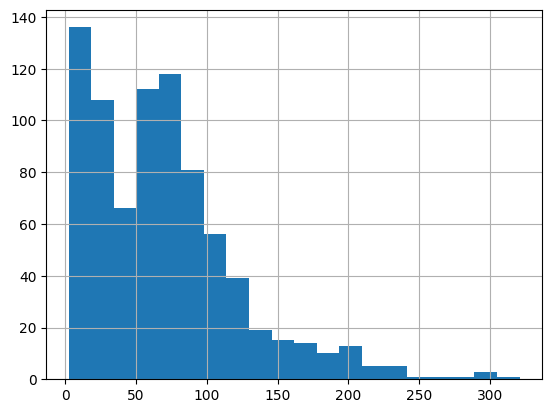

In [19]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~56463.50


<Axes: >

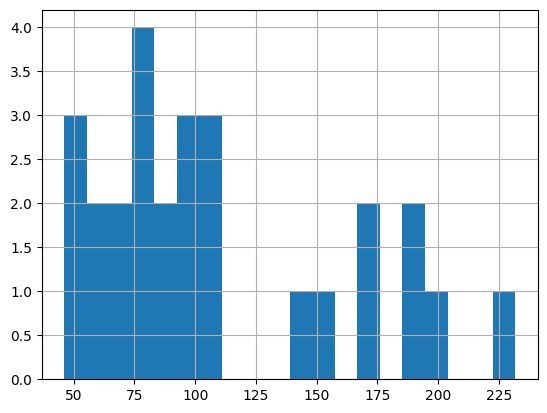

In [20]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='VMWare']['age'].hist(bins=20)

# Completely Random Shuffle

In [21]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [22]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [23]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [24]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [25]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // 5

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 804
Total card age: 56463.50


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,FSLogix,A full VHD(x) clone is performed when Cloud Ca...,71af619ba0f37ffd62aa637176cd6ef4,320.782724,113.360907,-320.782724,2040.496319,0.475305,18,0,0,-320.782724
276,FSLogix,All data written to the user's profile is temp...,42fa8ce841ec151bdccc63ec82f9e818,230.132396,113.360907,-320.782724,2040.496319,0.475305,18,1,0,-230.132396
545,FSLogix,"During a first-time sign-in, FSLogix creates t...",f2d84db5972e92abd44bdb7e0c5686a7,146.419766,113.360907,-320.782724,2040.496319,0.475305,18,2,0,-146.419766
1,FSLogix,FSLogix Application Masking:\nA component of F...,d0fddc21b0997167e4a59d514b6934e6,144.873286,113.360907,-320.782724,2040.496319,0.475305,18,3,0,-144.873286
277,FSLogix,VHD/VHDX:\nVirtual hard disk file formats used...,78dc61f911ee258e71b8a1e8b20ab6dd,119.726280,113.360907,-320.782724,2040.496319,0.475305,18,4,0,-119.726280
6,Vocab,"How to Sell a Haunted House, Hendrix\nDebride ...",1cbf1056a2336f69233d814a8be086c8,302.380156,104.533895,-302.380156,5122.160853,0.161110,49,0,0,-302.380156
282,Vocab,"Well of Lost Plots, Fforde\nEminence grise\nno...",ab06a932b5be8ff4bef2de903df7d4c9,201.486606,104.533895,-302.380156,5122.160853,0.161110,49,1,0,-201.486606
551,Vocab,"Jingo, Pratchett\nCrinoline\nnoun | KRIN-uh-li...",11b8182c8761879e9262b5797bbed0f4,199.575039,104.533895,-302.380156,5122.160853,0.161110,49,2,0,-199.575039
7,Vocab,"How to Sell a Haunted House, Hendrix\nTrimalle...",1cbfd950893772c1d42e4c3defaea154,194.172540,104.533895,-302.380156,5122.160853,0.161110,49,3,0,-194.172540
552,Vocab,"Well of Lost Plots, Fforde\nThe Decameron\nnou...",d9044a52b873016ee0bc48f05a511463,168.853096,104.533895,-302.380156,5122.160853,0.161110,49,4,0,-168.853096


## Card Count

In [26]:
# n=4
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [27]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [28]:
existing_cards.head(10)['age'].sum()

np.float64(2028.4018882218968)

In [29]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,FSLogix,A full VHD(x) clone is performed when Cloud Ca...,71af619ba0f37ffd62aa637176cd6ef4,320.782724,113.360907,-320.782724,2040.496319,0.475305,18,0,0,-320.782724
6,Vocab,"How to Sell a Haunted House, Hendrix\nDebride ...",1cbf1056a2336f69233d814a8be086c8,302.380156,104.533895,-302.380156,5122.160853,0.161110,49,0,0,-302.380156
49,Asynchronous Python,"Thread Pool Executor\nA thread pool executor, ...",102c628cf04ad4661a71d437cd297a11,302.351869,111.970259,-302.351869,3135.167263,0.103279,28,0,0,-302.351869
23,Python,Q:\nHow can you define a custom exception in P...,42a1f83efefd4b56173827e48cae56f3,300.884259,66.490564,-300.884259,5119.773429,0.576691,77,0,0,-300.884259
59,PnP PowerShell,Remove-PnPFile (PnP.PowerShell)\nDeletes a spe...,82aa6d1579ce68a7efaf6bae61eb3a03,273.407424,108.304743,-273.407424,4115.580217,0.304731,38,0,0,-273.407424
333,PnP PowerShell,Invoke-RestMethod Parameters\nKey parameters i...,e6a04d0a76f2a4a9cba720d23ffea2c8,262.048177,108.304743,-273.407424,4115.580217,0.304731,38,1,0,-262.048177
324,Asynchronous Python,asyncio.wait_for()\nRuns a coroutine with a ti...,0ccadcbce46e58eb4de4907f7e86cbf9,256.915062,111.970259,-302.351869,3135.167263,0.103279,28,1,0,-256.915062
298,Python,Q:\nWhat is the default exit code if a Python ...,b1c1e2234bc8df974f6b207465761b32,239.903695,66.490564,-300.884259,5119.773429,0.576691,77,1,0,-239.903695
72,Terraform,Built-In Functions:\nDefinition: Terraform pro...,11db06afec8fe1222dc3a034c10f3ebe,237.293681,119.165388,-237.293681,1191.653883,0.396441,10,0,0,-237.293681
76,VMWare,ESXi Shell\n\nA command-line interface (CLI) u...,29e8247f5a2aa78b7ff2123ac06ccfee,231.704481,110.124878,-231.704481,2973.371693,0.964981,27,0,0,-231.704481


In [30]:
existing_cards['age'].mean()

np.float64(70.22823492957687)